<a href="https://colab.research.google.com/github/rslowinski/102flower-classifier/blob/master/bert_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!nvidia-smi
!pip install tensorflow-gpu
!pip install --upgrade grpcio
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD


import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

Sun Jan 24 21:16:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
from tqdm import tqdm
data_path = '/Users/radoslawslowinski/private/university/pdwb/vine'
vine_filename = 'winemag-data-130k-v2.csv'


In [3]:
# df = pd.read_csv(os.path.join(data_path, vine_filename), index_col=[0])
df = pd.read_csv(vine_filename, index_col=[0])
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.variety.value_counts().head(15)

Pinot Noir                  221
Chardonnay                  216
Cabernet Sauvignon          196
Red Blend                   183
Bordeaux-style Red Blend    172
Riesling                    102
Syrah                        85
Sauvignon Blanc              83
Nebbiolo                     78
Rosé                         69
White Blend                  64
Merlot                       56
Malbec                       56
Sangiovese                   49
Portuguese Red               47
Name: variety, dtype: int64

In [5]:
df_mask = df.variety.isin(df.variety.value_counts().head(15).index)
df_golden = df[df_mask]
df_golden.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


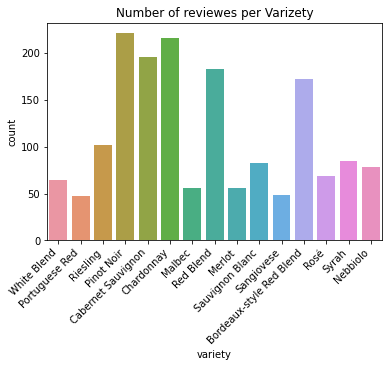

In [6]:
chart = sns.countplot(df_golden.variety)
plt.title("Number of reviewes per Varizety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [7]:
# Lets choice rating of wine is points, title as user_id, and variety,
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [8]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

In [9]:
for n in range(5):
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recmmendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')

Recmmendation for ## Cabernet Sauvignon-Syrah ##:
1: Marsanne with distance: 0.0
2: Muscat Blanc à Petits Grains with distance: 0.0
3: Charbono with distance: 0.0
4: G-S-M with distance: 0.0
5: Verdelho with distance: 0.0


Recmmendation for ## Sousão ##:
1: Portuguese White with distance: 0.5057775389860368
2: Portuguese Red with distance: 0.6734143117120002
3: Rosé with distance: 0.6812702802580077
4: Roditis with distance: 1.0
5: Roussanne with distance: 1.0


Recmmendation for ## Monastrell ##:
1: Monastrell with distance: 0.0
2: Red Blend with distance: 0.8129099211291428
3: Riesling with distance: 1.0
4: Roditis with distance: 1.0
5: Rosé with distance: 1.0


Recmmendation for ## Zinfandel ##:
1: Marsanne with distance: 0.0
2: Muscat Blanc à Petits Grains with distance: 0.0
3: Charbono with distance: 0.0
4: G-S-M with distance: 0.0
5: Verdelho with distance: 0.0


Recmmendation for ## Cabernet Franc ##:
1: Sémillon with distance: 0.3030397068385329
2: Grenache Blanc with distance

In [10]:
df_golden.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [11]:
df_bert = df_golden[['description', 'country', 'variety']]
df_bert.head()

,description,country,variety
0,"Aromas include tropical fruit, broom, brimston...",Italy,White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portugal,Portuguese Red
3,"Pineapple rind, lemon pith and orange blossom ...",US,Riesling
4,"Much like the regular bottling from 2012, this...",US,Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",US,Cabernet Sauvignon


In [12]:
df_bert['bert_input'] =  "Wine from " + df_golden['country'] + ". " + df_bert['description']
df_bert.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,description,country,variety,bert_input
0,"Aromas include tropical fruit, broom, brimston...",Italy,White Blend,Wine from Italy. Aromas include tropical fruit...
1,"This is ripe and fruity, a wine that is smooth...",Portugal,Portuguese Red,"Wine from Portugal. This is ripe and fruity, a..."
3,"Pineapple rind, lemon pith and orange blossom ...",US,Riesling,"Wine from US. Pineapple rind, lemon pith and o..."
4,"Much like the regular bottling from 2012, this...",US,Pinot Noir,Wine from US. Much like the regular bottling f...
10,"Soft, supple plum envelopes an oaky structure ...",US,Cabernet Sauvignon,"Wine from US. Soft, supple plum envelopes an o..."


In [13]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

--2021-01-24 21:17:57--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.28.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   175MB/s    in 2.2s    

2021-01-24 21:18:00 (175 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [27]:
class BertIntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        train, test = map(lambda df: df.reindex(df[BertIntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[BertIntentDetectionData.DATA_COLUMN], row[BertIntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_bert.bert_input, df_bert.variety, test_size = 0.2, random_state = 42)

train = { 'text': X_train, 'intent': y_train }
train_df = pd.DataFrame(train)
test = { 'text': X_test, 'intent': y_test }
test_df = pd.DataFrame(test)

In [18]:
train_df.head()


,text,intent
257,Wine from South Africa. This approachable Cabe...,Red Blend
684,Wine from US. This wine is aromatically reserv...,Cabernet Sauvignon
1929,"Wine from US. Mondavi's done it again, produce...",Cabernet Sauvignon
425,Wine from US. Blossom and berry notes are acce...,Rosé
236,"Wine from US. Shows rich, firm mountain tannin...",Cabernet Sauvignon


In [19]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))


In [30]:
def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")

    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    return model

In [34]:
classes = train_df.intent.unique().tolist()

data = BertIntentDetectionData(train_df, test_df, tokenizer, classes, max_seq_len=128)
model = create_model(data.max_seq_len, bert_ckpt_file)

model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

1341it [00:01, 1296.28it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
336it [00:00, 1297.74it/s]


max seq_len 157
bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f439fa2ab00> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [37]:
import datetime
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
76/76 [==============================] - 1402s 18s/step - loss: 2.9444 - acc: 0.0875 - val_loss: 2.4805 - val_acc: 0.2296
Epoch 2/5
76/76 [==============================] - 1366s 18s/step - loss: 2.7337 - acc: 0.1325 - val_loss: 2.3145 - val_acc: 0.1852
Epoch 3/5
76/76 [==============================] - 1344s 18s/step - loss: 2.5127 - acc: 0.2119 - val_loss: 2.0107 - val_acc: 0.4000
Epoch 4/5
76/76 [==============================] - 1350s 18s/step - loss: 2.2420 - acc: 0.2802 - val_loss: 1.7895 - val_acc: 0.4296
Epoch 5/5
76/76 [==============================] - 1338s 18s/step - loss: 2.0908 - acc: 0.3179 - val_loss: 1.6938 - val_acc: 0.4519


In [42]:
# _, train_acc = model.evaluate(data.train_x, data.train_y)
# _, test_acc = model.evaluate(data.test_x, data.test_y)

# print("train acc", train_acc)
# print("test acc", test_acc)


In [70]:
sentences = [
  "A blend of Merlot",
  "mature berry with Vermentino from Italy"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: A blend of Merlot 
intent: Red Blend

text: mature berry with Vermentino from Italy 
intent: White Blend



In [60]:
df_bert.country.value_counts()

US              784
France          281
Italy           240
Chile            81
Argentina        62
Portugal         59
Germany          35
Spain            33
Australia        28
New Zealand      21
Austria          18
South Africa     16
Israel            6
Romania           4
Greece            4
Hungary           2
Mexico            2
Slovenia          1
Name: country, dtype: int64

In [66]:
df_bert[df_bert.country == 'Italy']

,description,country,variety,bert_input
0,"Aromas include tropical fruit, broom, brimston...",Italy,White Blend,Wine from Italy. Aromas include tropical fruit...
22,Delicate aromas recall white flower and citrus...,Italy,White Blend,Wine from Italy. Delicate aromas recall white ...
26,Pretty aromas of yellow flower and stone fruit...,Italy,White Blend,Wine from Italy. Pretty aromas of yellow flowe...
28,"Aromas suggest mature berry, scorched earth, a...",Italy,Red Blend,"Wine from Italy. Aromas suggest mature berry, ..."
31,Merlot and Nero d'Avola form the base for this...,Italy,Red Blend,Wine from Italy. Merlot and Nero d'Avola form ...
...,...,...,...,...
2540,"A blend of Merlot, Cabernet Sauvignon, Caberne...",Italy,Red Blend,"Wine from Italy. A blend of Merlot, Cabernet S..."
2562,"Aromas of ripe berry, Mediterranean herb, ment...",Italy,Red Blend,"Wine from Italy. Aromas of ripe berry, Mediter..."
2570,"Made with 80% Nasco and 20% Vermentino, this o...",Italy,White Blend,Wine from Italy. Made with 80% Nasco and 20% V...
2591,This traditionally styled Barolo has a classic...,Italy,Nebbiolo,Wine from Italy. This traditionally styled Bar...
